In [9]:
from main import MainProgram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import main
import importlib
importlib.reload(main)
from scipy.interpolate import griddata

In [10]:
target = 'LHS1140b'  # Exoplanet name

out_file = f"simulation_results_{target}.txt"
if os.path.exists(out_file):
    os.remove(out_file)
    print(f"Previous file '{out_file}' removed. Creating a new one...")
else:
    print(f"No existing file named '{out_file}'. A new one will be created...")

############## Code Parameters - No changes required ############################

intensidadeMaxima = 1000
min_pixels = 100 # minimum allowed matrix size
max_pixels = 2000 # maximum allowed matrix size
pixels_per_rp = 55 # desired pixels per planetary radius

Previous file 'simulation_results_LHS1140b.txt' removed. Creating a new one...


In [11]:
############## Main Parameters ############################

########## Star #################
raioStar = 0.2159 # [R_sun]
massStar = 0.1844 # [M_sun]
tempStar = 3100 # [K]
######### Planet ################
raioPlanetaRj = 0.1543 # [Rj] (in in jupiter's radius)
######### Orbital Parameters ####
periodo = 24.73723 # [days]
anguloInclinacao = 89.86 # [deg]
semiEixoUA = 0.0946 # [AU]
ecc = 0
anom = 0

In [12]:
############## Plot Options ###############################

plot_anim = False
plot_star = False
plot_graph = False

In [13]:
############## LD Coefficients ############################


# Define column names manually (based on your file)
column_names = [
    'Teff', 'logg', 'FeH', 'profile', 'filter',
    'wave_min', 'wave_eff', 'wave_max',
    'c1', 'e1', 'c2', 'e2', 'c3', 'e3', 'c4', 'e4'
]

# Read the file, skipping the first 2 lines: header + dashed line
table_ExoCTK = pd.read_csv(
    'ExoCTK_results.txt',
    sep=r'\s+',              # Use regex to split on variable whitespace
    skiprows=2,              # Skip header and separator line
    names=column_names,      # Use correct column names
    engine='python',         # Regex splitting requires python engine
    keep_default_na=False
)

# Now the data is usable as expected
c1 = table_ExoCTK['c1'].to_numpy()
c2 = table_ExoCTK['c2'].to_numpy()
c3 = table_ExoCTK['c3'].to_numpy()
c4 = table_ExoCTK['c4'].to_numpy()

unique_profiles = table_ExoCTK['profile'].unique()
if len(unique_profiles) == 1:
    profile = unique_profiles[0]
else:
    print("Warning: Multiple profile types found:", unique_profiles)


lambdaEff = table_ExoCTK['wave_eff'].astype(float).to_numpy()

num_elements = len(c1)

In [14]:
import warnings
############## Starspots/Faculae ##########################
starspots = True # Caution! Do not change to False

both_mode = False
number_active_region = 3

if both_mode:
    lat = np.array([15,15]) # position ([fac,spot])
    longt = np.array([-20,20]) # position ([fac,spot])
    quantidade = len(lat) # quantity of regions = 2
else:
    lat = np.array([15,15,15]) # insert the latitude of the spots in deg. Ex: for 3 spots: np.array([20, 20, 20]) 
    longt = np.array([-20,0,20]) # insert the latitude of the spots in deg. Ex: for 3 spots: np.array([-20, 0, 20])
    quantidade = len(lat) # quantity of spots
    # Check if the number of regions matches the expected number
    if number_active_region != quantidade:
        warnings.warn(
            f"The number of active regions defined in lat and longt does not match 'number_active_region'. "
            "Please verify the positions or number_active_region. Simulation aborted."
        )
        raise RuntimeError("Simulation stopped due to mismatch in the number of active regions.")


In [15]:
############## Interpolation Parameters ###################

delta_T = 300
step_T = 30

# Spot simulation parameters
ff_spot_min = 0.01
ff_spot_max = 0.15
T_spot_min = tempStar - delta_T
T_spot_max = tempStar - step_T
num_ff_spot_simulations = 3
num_T_spot_simulations = 3

# Facula simulation parameters (mirrored above T_star)
ff_fac_min = 0.01
ff_fac_max = 0.15
T_fac_min = tempStar + step_T
T_fac_max = tempStar + delta_T
num_ff_fac_simulations = 3
num_T_fac_simulations = 3

num_ff_interpolations = 30      # Para f_spot
num_T_spot_interpolations = 30  # Para T_spot
num_ff_fac_interpolations = 30  # Para f_facula
num_T_fac_interpolations = 20   # Para T_facula



Running the unspotted scenario (ff=0) first, so it appears first in the results file.
[UNSPOTTED] ff=0.0, T=3100


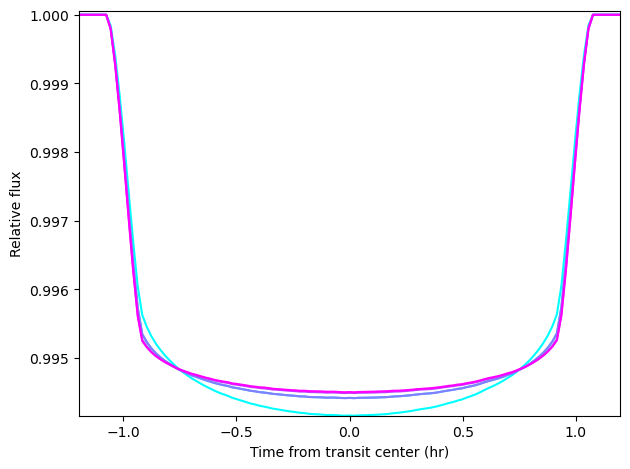

[SPOT] ff=0.010, T_spot=2800.0


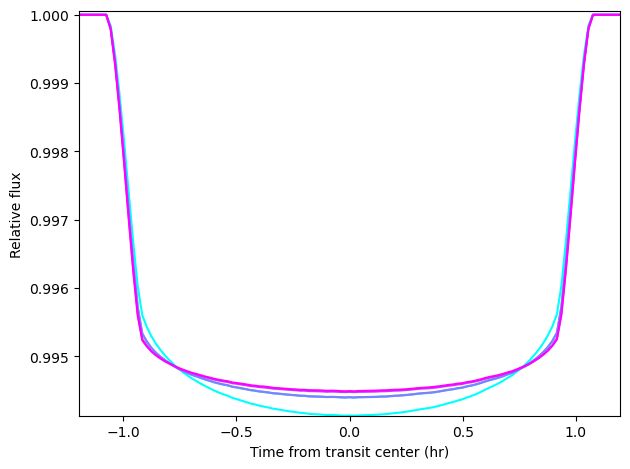

[SPOT] ff=0.010, T_spot=2935.0


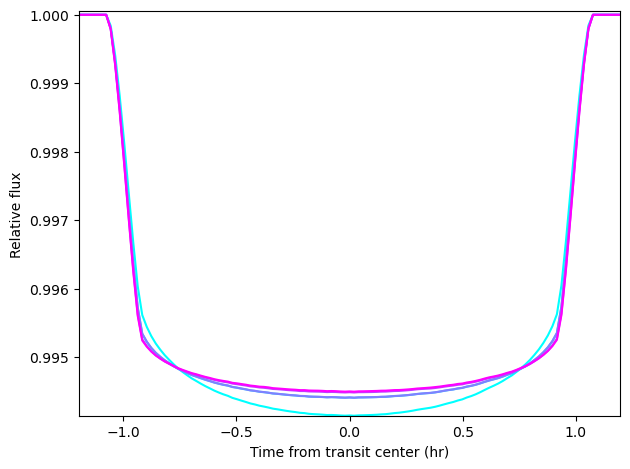

[SPOT] ff=0.010, T_spot=3070.0


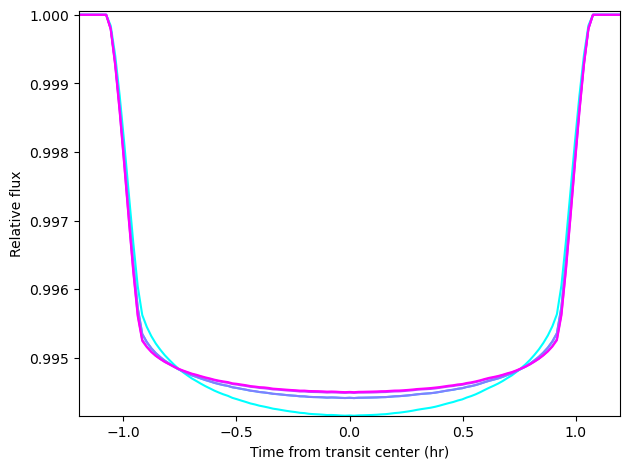

[SPOT] ff=0.080, T_spot=2800.0


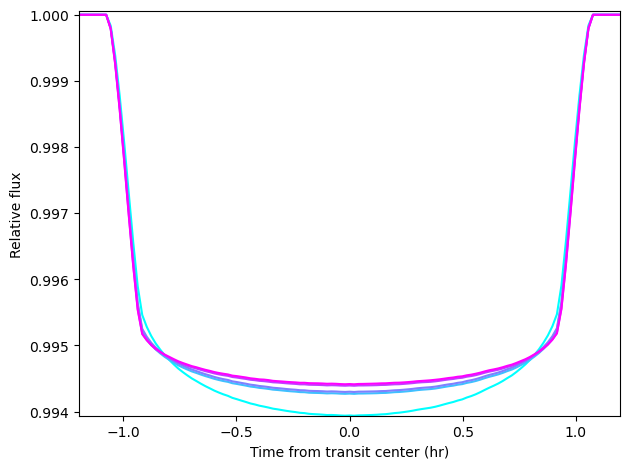

[SPOT] ff=0.080, T_spot=2935.0


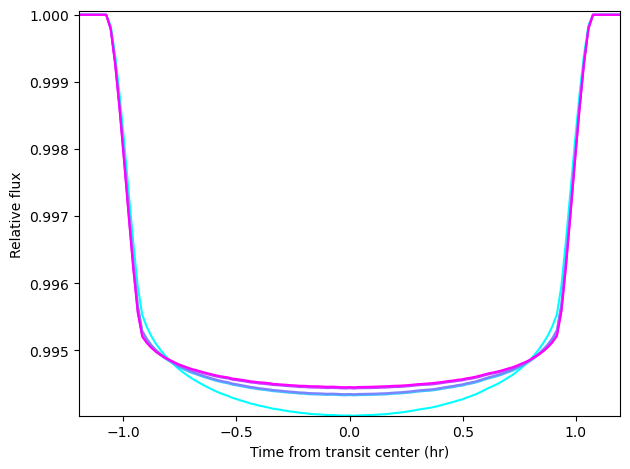

[SPOT] ff=0.080, T_spot=3070.0


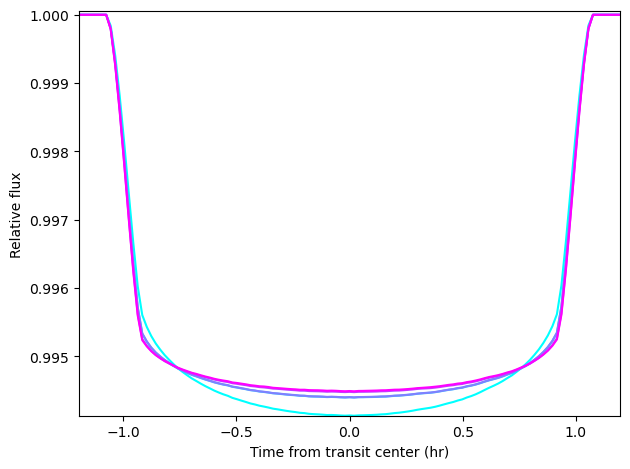

[SPOT] ff=0.150, T_spot=2800.0


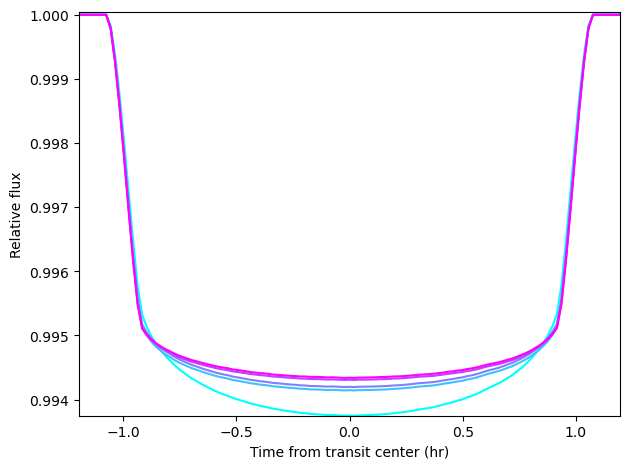

[SPOT] ff=0.150, T_spot=2935.0


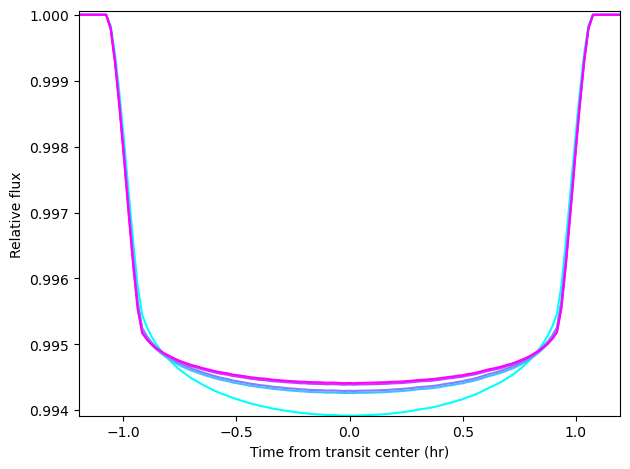

[SPOT] ff=0.150, T_spot=3070.0


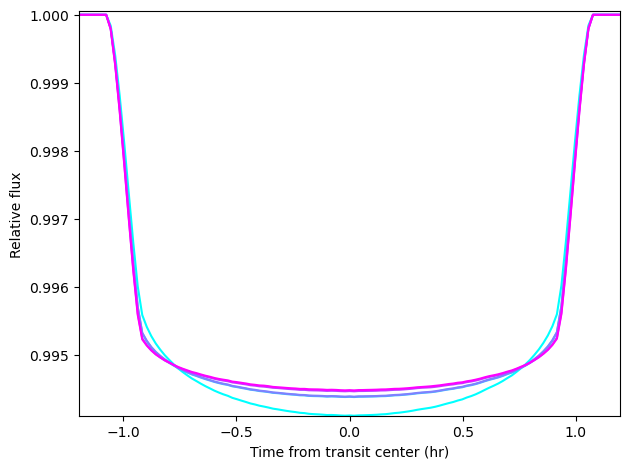

[FACULAE] ff=0.010, T_fac=3130.0


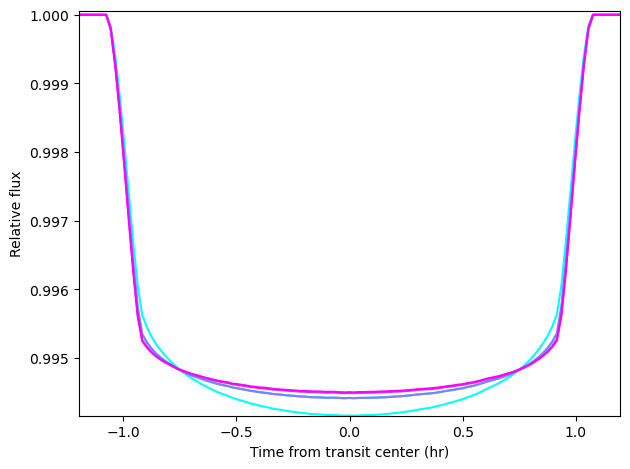

[FACULAE] ff=0.010, T_fac=3265.0


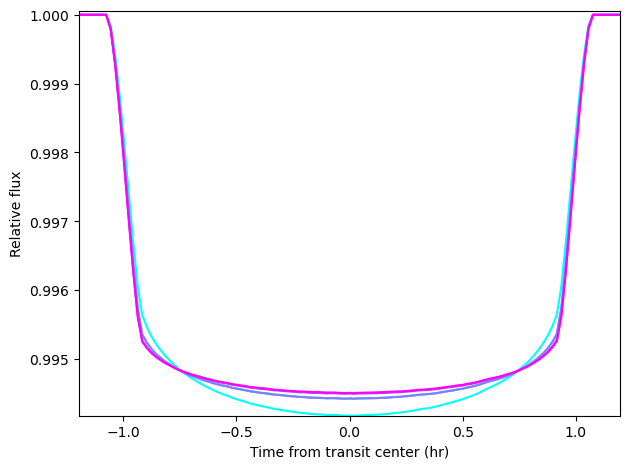

[FACULAE] ff=0.010, T_fac=3400.0


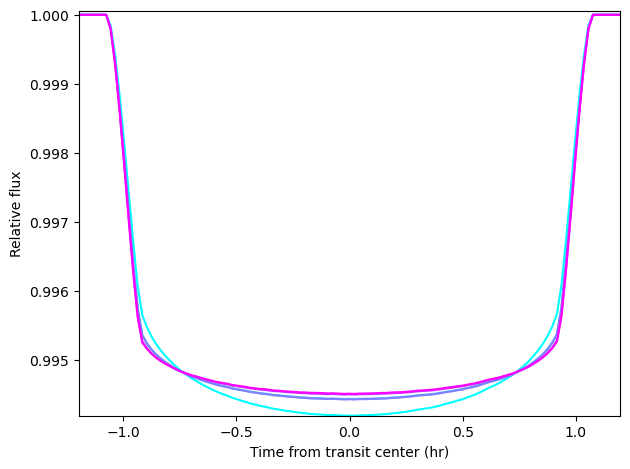

[FACULAE] ff=0.080, T_fac=3130.0


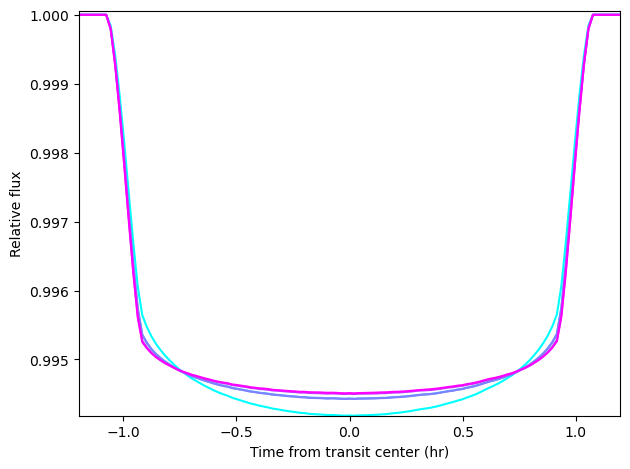

[FACULAE] ff=0.080, T_fac=3265.0


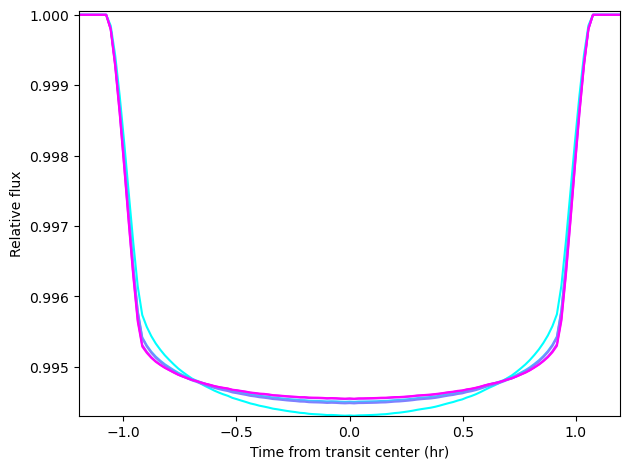

[FACULAE] ff=0.080, T_fac=3400.0


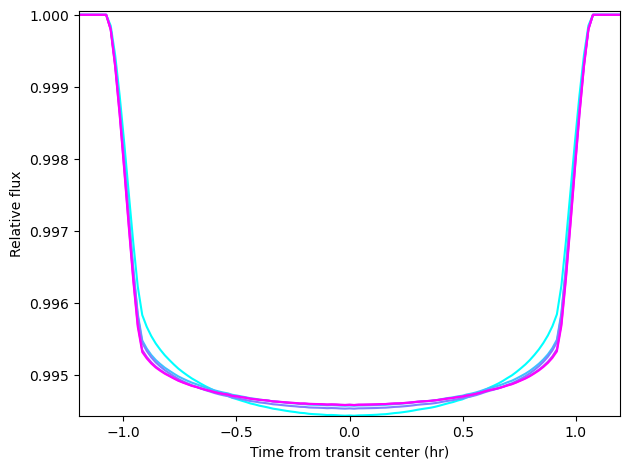

[FACULAE] ff=0.150, T_fac=3130.0


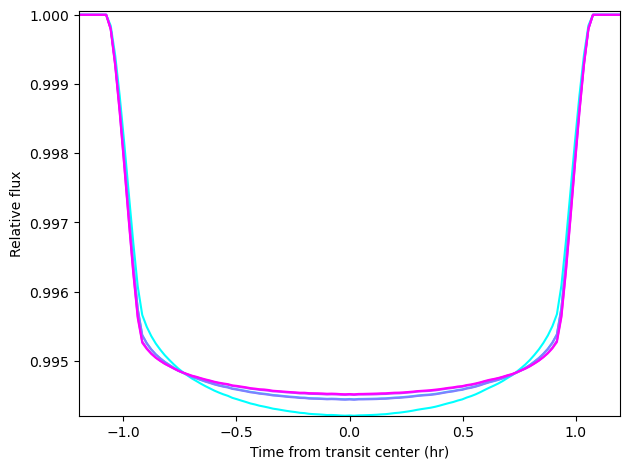

[FACULAE] ff=0.150, T_fac=3265.0


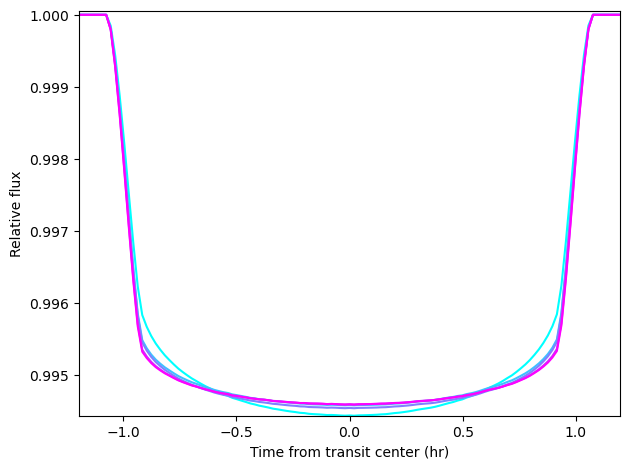

[FACULAE] ff=0.150, T_fac=3400.0


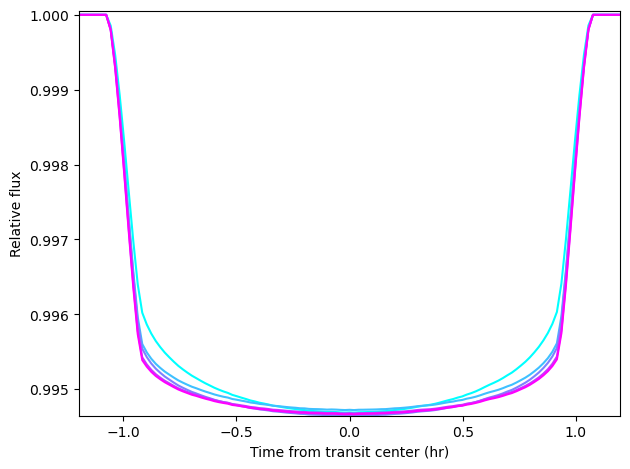

Simulations completed for LHS1140b. Results saved in 'simulation_results_LHS1140b.txt'.


In [16]:
import numpy as np

def run_simulations(
    ff_spot_min, ff_spot_max,
    T_spot_min, T_spot_max,
    num_ff_spot_simulations,
    num_T_spot_simulations,
    other_params,
    both_mode,
    result_type="spot",
    ff_facula_min=None,
    ff_facula_max=None,
    T_facula_min=None,
    T_facula_max=None,
    num_ff_facula_simulations=None,
    num_T_facula_simulations=None,
):
    grid_ff_spot = np.linspace(ff_spot_min, ff_spot_max, num_ff_spot_simulations)
    grid_T_spot = np.linspace(T_spot_min, T_spot_max, num_T_spot_simulations)

    if both_mode:
        grid_ff_facula = np.linspace(ff_facula_min, ff_facula_max, num_ff_facula_simulations)
        grid_T_facula = np.linspace(T_facula_min, T_facula_max, num_T_facula_simulations)

        for ff_s in grid_ff_spot:
            for T_s in grid_T_spot:
                for ff_f in grid_ff_facula:
                    for T_f in grid_T_facula:
                        iteration_params = other_params.copy()
                        iteration_params["simulation_mode"] = "both"
                        iteration_params["fillingFactor"] = [ff_f, ff_s]  # [facula, spot]
                        iteration_params["tempFacula"] = T_f
                        iteration_params["tempSpot"] = T_s

                        iteration_params['r_spot'] = np.sqrt(ff_s)
                        print("r_spot: ", iteration_params['r_spot'])
                        iteration_params['r_facula'] = np.sqrt(ff_f)
                        print("r_facula: ", iteration_params['r_facula'])
                        iteration_params['r'] = None  # desativado no modo both

                        print(f"[BOTH] ff_spot={ff_s:.3f}, T_spot={T_s} | ff_facula={ff_f:.3f}, T_facula={T_f}")

                        MainProgram(
                            target=iteration_params["target"],
                            num_elements=iteration_params["num_elements"],
                            profile=iteration_params["profile"],
                            c1=iteration_params["c1"],
                            c2=iteration_params["c2"],
                            c3=iteration_params["c3"],
                            c4=iteration_params["c4"],
                            lambdaEff=iteration_params["lambdaEff"],
                            intensidadeMaxima=iteration_params["intensidadeMaxima"],
                            raioStar=iteration_params["raioStar"],
                            ecc=iteration_params["ecc"],
                            anom=iteration_params["anom"],
                            tempStar=iteration_params["tempStar"],
                            simulation_mode=iteration_params["simulation_mode"],
                            tempSpot=iteration_params["tempSpot"],
                            tempFacula=iteration_params["tempFacula"],
                            fillingFactor=iteration_params["fillingFactor"],
                            starspots=iteration_params["starspots"],
                            quantidade=iteration_params["quantidade"],
                            lat=iteration_params["lat"],
                            longt=iteration_params["longt"],
                            r=iteration_params["r"],
                            r_spot=iteration_params["r_spot"],
                            r_facula=iteration_params["r_facula"],
                            semiEixoUA=iteration_params["semiEixoUA"],
                            massStar=iteration_params["massStar"],
                            plot_anim=iteration_params["plot_anim"],
                            periodo=iteration_params["periodo"],
                            anguloInclinacao=iteration_params["anguloInclinacao"],
                            raioPlanetaRj=iteration_params["raioPlanetaRj"],
                            plot_graph=iteration_params["plot_graph"],
                            plot_star=iteration_params["plot_star"],
                            min_pixels=iteration_params["min_pixels"],
                            max_pixels=iteration_params["max_pixels"],
                            pixels_per_rp=iteration_params["pixels_per_rp"],
                            both_mode=iteration_params["both_mode"]
                        )
                        
    else:
        for ff in grid_ff_spot:
            for T_spot in grid_T_spot:
                iteration_params = other_params.copy()
                iteration_params["simulation_mode"] = result_type

                if not (0 <= ff <= 1):
                    raise ValueError(f"Invalid ff={ff}. Must be in range [0, 1].")

                iteration_params["r"] = np.sqrt(ff / max(iteration_params.get("quantidade", 1), 1))
                iteration_params["r_spot"] = None
                iteration_params["r_facula"] = None

                if result_type == "faculae":
                    iteration_params["tempFacula"] = T_spot
                    iteration_params["tempSpot"] = None
                    iteration_params["fillingFactor"] = [ff]
                    print(f"[FACULAE] ff={ff:.3f}, T_fac={T_spot}")
                elif result_type == "spot":
                    iteration_params["tempSpot"] = T_spot
                    iteration_params["tempFacula"] = None
                    iteration_params["fillingFactor"] = [ff]
                    print(f"[SPOT] ff={ff:.3f}, T_spot={T_spot}")
                elif result_type == "unspotted":
                    iteration_params["tempSpot"] = iteration_params["tempStar"]
                    iteration_params["starspots"] = False
                    iteration_params["tempFacula"] = None
                    iteration_params["fillingFactor"] = [0.0]
                    print(f"[UNSPOTTED] ff=0.0, T={iteration_params['tempStar']}")
                else:
                    iteration_params["tempSpot"] = T_spot
                    iteration_params["tempFacula"] = None
                    iteration_params["fillingFactor"] = [ff]
                    print(f"[{result_type.upper()}] ff={ff:.3f}, T={T_spot}")

                MainProgram(
                    target=iteration_params["target"],
                    num_elements=iteration_params["num_elements"],
                    profile=iteration_params["profile"],
                    c1=iteration_params["c1"],
                    c2=iteration_params["c2"],
                    c3=iteration_params["c3"],
                    c4=iteration_params["c4"],
                    lambdaEff=iteration_params["lambdaEff"],
                    intensidadeMaxima=iteration_params["intensidadeMaxima"],
                    raioStar=iteration_params["raioStar"],
                    ecc=iteration_params["ecc"],
                    anom=iteration_params["anom"],
                    tempStar=iteration_params["tempStar"],
                    simulation_mode=iteration_params["simulation_mode"],
                    tempSpot=iteration_params["tempSpot"],
                    tempFacula=iteration_params["tempFacula"],
                    fillingFactor=iteration_params["fillingFactor"],
                    starspots=iteration_params["starspots"],
                    quantidade=iteration_params["quantidade"],
                    lat=iteration_params["lat"],
                    longt=iteration_params["longt"],
                    r=iteration_params["r"],
                    r_spot=iteration_params["r_spot"],
                    r_facula=iteration_params["r_facula"],
                    semiEixoUA=iteration_params["semiEixoUA"],
                    massStar=iteration_params["massStar"],
                    plot_anim=iteration_params["plot_anim"],
                    periodo=iteration_params["periodo"],
                    anguloInclinacao=iteration_params["anguloInclinacao"],
                    raioPlanetaRj=iteration_params["raioPlanetaRj"],
                    plot_graph=iteration_params["plot_graph"],
                    plot_star=iteration_params["plot_star"],
                    min_pixels=iteration_params["min_pixels"],
                    max_pixels=iteration_params["max_pixels"],
                    pixels_per_rp=iteration_params["pixels_per_rp"],
                    both_mode=iteration_params["both_mode"]
                )

    return grid_ff_spot, grid_T_spot


# Ajuste do dicionário de parâmetros sem valores fixos inválidos
other_params = {
    'num_elements': num_elements,
    'profile': profile,
    'c1': c1,
    'c2': c2,
    'c3': c3,
    'c4': c4,
    'lambdaEff': lambdaEff,
    'target': target,
    'intensidadeMaxima': intensidadeMaxima,
    'raioStar': raioStar,
    'ecc': ecc,
    'anom': anom,
    'tempStar': tempStar,
    'simulation_mode': None,        # vai ser setado dinamicamente
    'fillingFactor': None,          # idem
    'starspots': starspots,
    'quantidade': quantidade,
    'lat': lat,
    'longt': longt,
    'semiEixoUA': semiEixoUA,
    'massStar': massStar,
    'plot_anim': plot_anim,
    'periodo': periodo,
    'anguloInclinacao': anguloInclinacao,
    'raioPlanetaRj': raioPlanetaRj,
    'plot_graph': plot_graph,
    'plot_star': plot_star,
    'min_pixels': min_pixels,
    'max_pixels': max_pixels,
    'pixels_per_rp': pixels_per_rp,
    'both_mode': both_mode
}


# ======================== EXECUTION ========================

print("\nRunning the unspotted scenario (ff=0) first, so it appears first in the results file.")
unspotted_params = other_params.copy()
unspotted_params['r'] = 0.0
unspotted_params['tempSpot'] = tempStar
unspotted_params['starspots'] = False

# Run unspotted first
run_simulations(
    ff_spot_min=0.0,
    ff_spot_max=0.0,
    T_spot_min=tempStar,
    T_spot_max=tempStar,
    num_ff_spot_simulations=1,
    num_T_spot_simulations=1,
    other_params=unspotted_params,
    both_mode=False,
    result_type="unspotted"
)

# Ensure starspots are active
starspots = True

# Run SPOTS
run_simulations(
    ff_spot_min=ff_spot_min,
    ff_spot_max=ff_spot_max,
    T_spot_min=T_spot_min,
    T_spot_max=T_spot_max,
    num_ff_spot_simulations=num_ff_spot_simulations,
    num_T_spot_simulations=num_T_spot_simulations,
    other_params=other_params,
    both_mode=False,
    result_type="spot"
)

# Run FACULAE
run_simulations(
    ff_spot_min=ff_fac_min,
    ff_spot_max=ff_fac_max,
    T_spot_min=T_fac_min,
    T_spot_max=T_fac_max,
    num_ff_spot_simulations=num_ff_fac_simulations,
    num_T_spot_simulations=num_T_fac_simulations,
    other_params=other_params,
    both_mode=False,
    result_type="faculae"
)

# ✅ Run BOTH (spots + faculae together)
if both_mode:
    run_simulations(
        ff_spot_min=ff_spot_min,
        ff_spot_max=ff_spot_max,
        T_spot_min=T_spot_min,
        T_spot_max=T_spot_max,
        num_ff_spot_simulations=num_ff_spot_simulations,
        num_T_spot_simulations=num_T_spot_simulations,
        
        ff_facula_min=ff_fac_min,
        ff_facula_max=ff_fac_max,
        T_facula_min=T_fac_min,
        T_facula_max=T_fac_max,
        num_ff_facula_simulations=num_ff_fac_simulations,
        num_T_facula_simulations=num_T_fac_simulations,

        other_params=other_params,
        both_mode=True,
        result_type="both"
    )

    
print(f"Simulations completed for {target}. Results saved in 'simulation_results_{target}.txt'.")

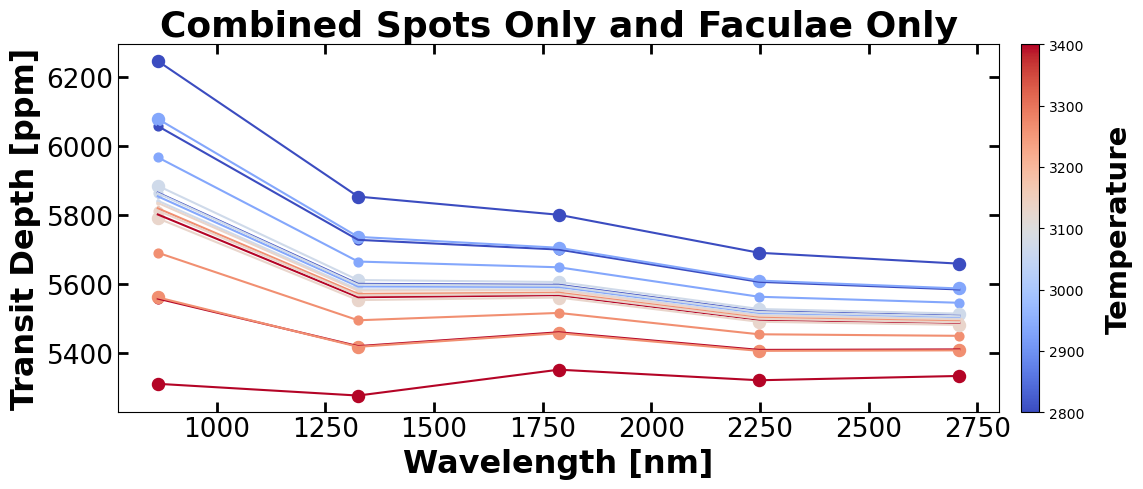

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import os
import matplotlib

# --- File and plotting configuration ---
file_path = f"simulation_results_{target}.txt"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# --- Load simulation data ---
data = np.genfromtxt(file_path, delimiter=',', names=True)

# --- Define masks using temperature columns ---
# Spots Only: valid tempSpot and missing tempFacula
is_spot_only = ~np.isnan(data['tempSpot']) & np.isnan(data['tempFacula'])
# Faculae Only: missing tempSpot and valid tempFacula
is_facula_only = np.isnan(data['tempSpot']) & ~np.isnan(data['tempFacula'])
# Spots + Faculae: both temperatures available
is_both = ~np.isnan(data['tempSpot']) & ~np.isnan(data['tempFacula'])

# --- Store generated figures ---
figures = {}

# --- Scale factor for symbol size based on filling factor ---
marker_scale = 500  # adjust as needed

if both_mode:
    # ====================================================
    # FIGURE A: Combined plot for Spots Only and Faculae Only
    # ====================================================
    combined = np.concatenate([data[is_spot_only], data[is_facula_only]])
    groups = {}
    for row in combined:
        # Use temperature columns to determine group:
        # If tempFacula is NaN then this row is "Spots Only"
        if np.isnan(row['tempFacula']):
            fill = row['f_spot']       # use spot filling factor
            temp = row['tempSpot']     # use spot temperature
        # Otherwise, if tempSpot is NaN then it's "Faculae Only"
        elif np.isnan(row['tempSpot']):
            fill = row['f_facula']     # use facula filling factor
            temp = row['tempFacula']   # use facula temperature
        else:
            # In principle, these rows should not occur in the combined plot.
            continue

        key = (fill, temp)
        if key not in groups:
            groups[key] = {'wavelength': [], 'D': []}
        groups[key]['wavelength'].append(row['wavelength'])
        groups[key]['D'].append(row['D_lambda'])
    
    # Prepare temperature data for color scaling (ignoring NaNs)
    temps = np.array([key[1] for key in groups.keys() if not np.isnan(key[1])])
    if temps.size == 0:
        print("No valid temperature data found for Spots Only and Faculae Only. Skipping combined plot.")
    else:
        t_min, t_max = np.nanmin(temps), np.nanmax(temps)
        cmap_t = matplotlib.colormaps["coolwarm"]
        norm_t = Normalize(vmin=t_min, vmax=t_max)
    
        figA, axA = plt.subplots(figsize=(12, 5))
    
        for (fill, temp), values in groups.items():
            if np.isnan(temp):
                continue
            lam_array = np.array(values['wavelength'])
            d_array = np.array(values['D'])
            idx = np.argsort(lam_array)
            size = marker_scale * fill  # Marker size based on filling factor
            color = cmap_t(norm_t(temp))
            axA.scatter(lam_array[idx], d_array[idx], s=size, color=color, alpha=1)
            axA.plot(lam_array[idx], d_array[idx], color=color, alpha=1)
    
        axA.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
        axA.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
        axA.tick_params(axis="x", direction="in", labelsize=19, width=2, length=7, pad=3, top=True)
        axA.tick_params(axis="y", direction="in", labelsize=19, width=2, length=7, pad=3, right=True)
        axA.set_title("Combined Spots Only and Faculae Only", fontsize=26, fontweight='bold')
    
        smA = ScalarMappable(cmap=cmap_t, norm=norm_t)
        smA.set_array([])
        cbarA = figA.colorbar(smA, ax=axA, orientation='vertical', pad=0.02)
        cbarA.set_label("Temperature", fontsize=21, fontweight='bold', labelpad=15)
    
        figA.tight_layout()
        figures["Combined"] = figA

    # ====================================================
    # FIGURE B: Plot for Spots + Faculae
    # ====================================================

    # FIGURE B: Plot for Spots + Faculae with color based on temperature
    figB, axB = plt.subplots(figsize=(12, 5))

    if data[is_both].size == 0:
        # No data for Spots+Faculae: display a message on the plot
        axB.text(0.5, 0.5, "No Spots+Faculae Data Available", 
                ha='center', va='center', fontsize=20)
        axB.set_title("Spots + Faculae", fontsize=26, fontweight='bold')
        axB.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
        axB.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
    else:
        groups_both = {}
        for row in data[is_both]:
            # More specific key: (f_spot, tempSpot, f_facula, tempFacula)
            key = (row['f_spot'], row['tempSpot'], row['f_facula'], row['tempFacula'])
            if key not in groups_both:
                groups_both[key] = {'wavelength': [], 'D': []}
            groups_both[key]['wavelength'].append(row['wavelength'])
            groups_both[key]['D'].append(row['D_lambda'])

        # Use the facula temperature for color mapping (index 3)
        temp_vals = np.array([k[3] for k in groups_both.keys() if not np.isnan(k[3])])
        if temp_vals.size == 0:
            print("No valid facula temperature data found for Spots + Faculae. Plotting empty figure.")
        else:
            t_min_b, t_max_b = np.nanmin(temp_vals), np.nanmax(temp_vals)
            cmap_b = matplotlib.colormaps["coolwarm"]
            norm_b = Normalize(vmin=t_min_b, vmax=t_max_b)

            for (f_spot, t_spot, f_fac, t_fac), values in groups_both.items():
                if np.isnan(t_fac):
                    continue
                lam_array = np.array(values['wavelength'])
                d_array = np.array(values['D'])
                idx = np.argsort(lam_array)
                # Marker size is based on f_spot
                size = marker_scale * f_spot
                # Color is now based on facula temperature (t_fac)
                color = cmap_b(norm_b(t_fac))
                axB.scatter(lam_array[idx], d_array[idx], s=size, color=color, alpha=1)
                axB.plot(lam_array[idx], d_array[idx], color=color, alpha=1)

            smB = ScalarMappable(cmap=cmap_b, norm=norm_b)
            smB.set_array([])
            # Update colorbar label to "Temperature"
            cbarB = figB.colorbar(smB, ax=axB, orientation='vertical', pad=0.02)
            cbarB.set_label("Temperature", fontsize=21, fontweight='bold', labelpad=15)

        axB.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
        axB.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
        axB.tick_params(axis="x", direction="in", labelsize=19, width=2, length=7, pad=3, top=True)
        axB.tick_params(axis="y", direction="in", labelsize=19, width=2, length=7, pad=3, right=True)
        axB.set_title("Spots + Faculae", fontsize=26, fontweight='bold')

    figB.tight_layout()
    figures["Spots + Faculae"] = figB

else:
    # ====================================================
    # both_mode == False: Only combined plot of Spots Only and Faculae Only
    # ====================================================
    combined = np.concatenate([data[is_spot_only], data[is_facula_only]])
    groups = {}
    for row in combined:
        if np.isnan(row['tempFacula']):
            fill = row['f_spot']
            temp = row['tempSpot']
        elif np.isnan(row['tempSpot']):
            fill = row['f_facula']
            temp = row['tempFacula']
        else:
            continue
        key = (fill, temp)
        if key not in groups:
            groups[key] = {'wavelength': [], 'D': []}
        groups[key]['wavelength'].append(row['wavelength'])
        groups[key]['D'].append(row['D_lambda'])
    
    temps = np.array([key[1] for key in groups.keys() if not np.isnan(key[1])])
    if temps.size == 0:
        print("No valid temperature data found for Spots Only and Faculae Only. Skipping combined plot.")
    else:
        t_min, t_max = np.nanmin(temps), np.nanmax(temps)
        cmap_t = matplotlib.colormaps["coolwarm"]
        norm_t = Normalize(vmin=t_min, vmax=t_max)
    
        fig, ax = plt.subplots(figsize=(12, 5))
    
        for (fill, temp), values in groups.items():
            if np.isnan(temp):
                continue
            lam_array = np.array(values['wavelength'])
            d_array = np.array(values['D'])
            idx = np.argsort(lam_array)
            size = marker_scale * fill
            color = cmap_t(norm_t(temp))
            ax.scatter(lam_array[idx], d_array[idx], s=size, color=color, alpha=1)
            ax.plot(lam_array[idx], d_array[idx], color=color, alpha=1)
    
        ax.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
        ax.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
        ax.tick_params(axis="x", direction="in", labelsize=19, width=2, length=7, pad=3, top=True)
        ax.tick_params(axis="y", direction="in", labelsize=19, width=2, length=7, pad=3, right=True)
        ax.set_title("Combined Spots Only and Faculae Only", fontsize=26, fontweight='bold')
    
        sm = ScalarMappable(cmap=cmap_t, norm=norm_t)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label("Temperature", fontsize=21, fontweight='bold', labelpad=15)
    
        fig.tight_layout()
        figures["Combined"] = fig

plt.show()

In [18]:
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator

# Function to load simulation data, treating empty fields as np.nan
def load_simulation_data(file_path):
    data = np.genfromtxt(
        file_path,
        delimiter=',',
        skip_header=1,
        dtype=float,
        missing_values='',
        filling_values=np.nan
    )
    return data.T  # Transpose for easier extraction of columns

# --- Simulation Grids (used when running the simulations) ---
unique_ff_spot = np.linspace(ff_spot_min, ff_spot_max, num_ff_spot_simulations)
unique_T_spot  = np.linspace(T_spot_min, T_spot_max, num_T_spot_simulations)
unique_ff_fac  = np.linspace(ff_fac_min, ff_fac_max, num_ff_fac_simulations)
unique_T_fac   = np.linspace(T_fac_min, T_fac_max, num_T_fac_simulations)

# --- Finer Interpolation Grids ---
ff_spot_interp = np.linspace(ff_spot_min, ff_spot_max, num_ff_interpolations)
T_spot_interp  = np.linspace(T_spot_min, T_spot_max, num_T_spot_interpolations)
ff_fac_interp  = np.linspace(ff_fac_min, ff_fac_max, num_ff_fac_interpolations)
T_fac_interp   = np.linspace(T_fac_min, T_fac_max, num_T_fac_interpolations)

# --- Define the file path for the simulation results ---
file_path = f"simulation_results_{target}.txt"

# === INTERPOLATION FUNCTIONS ===

def interpolate_results_spot(file_path):
    """
    Interpolates spot-only simulation results (f_spot > 0, f_facula is NaN) over a finer 2D grid.
    """
    f_spot_data, T_spot_data, f_fac_data, T_fac_data, wavelength_data, D_lambda_data = load_simulation_data(file_path)

    # ✅ Only keep spot-only cases: f_spot > 0 and f_facula is NaN
    spot_mask = (f_spot_data > 0) & (np.isnan(f_fac_data))

    f_spot_data = f_spot_data[spot_mask]
    T_spot_data = T_spot_data[spot_mask]
    wavelength_data = wavelength_data[spot_mask]
    D_lambda_data = D_lambda_data[spot_mask]

    results = []
    unique_wl = np.unique(wavelength_data)
    expected_size = num_ff_spot_simulations * num_T_spot_simulations

    for wl in unique_wl:
        mask_wl = (wavelength_data == wl)
        if np.sum(mask_wl) != expected_size:
            print(f"[!] Warning (spot): For wavelength {wl}, found {np.sum(mask_wl)} points (expected {expected_size}). Skipping.")
            continue

        df = pd.DataFrame({
            'f_spot': f_spot_data[mask_wl],
            'T_spot': T_spot_data[mask_wl],
            'D_lambda': D_lambda_data[mask_wl]
        })

        grouped = df.groupby(['f_spot', 'T_spot'], as_index=False).mean()
        unique_f_spot = np.sort(grouped['f_spot'].unique())
        unique_T_spot = np.sort(grouped['T_spot'].unique())
        expected_grp = len(unique_f_spot) * len(unique_T_spot)

        if grouped.shape[0] != expected_grp:
            print(f"[!] Warning (spot): For wavelength {wl}, grouped points {grouped.shape[0]} != expected {expected_grp}. Skipping.")
            continue

        D_grid = grouped['D_lambda'].values.reshape((len(unique_f_spot), len(unique_T_spot)))
        interpolator = RegularGridInterpolator(
            (unique_f_spot, unique_T_spot),
            D_grid,
            method='linear',
            bounds_error=False,
            fill_value=np.nan
        )

        grid_ff, grid_T = np.meshgrid(ff_spot_interp, T_spot_interp, indexing='ij')
        query_points = np.column_stack((grid_ff.ravel(), grid_T.ravel()))
        interp_vals = interpolator(query_points)

        for (ff_val, T_val), d_val in zip(query_points, interp_vals):
            results.append([ff_val, T_val, np.nan, np.nan, wl, d_val])

    return pd.DataFrame(results, columns=["f_spot", "T_spot", "f_facula", "T_facula", "wavelength", "D_lambda"])


def interpolate_results_facula(file_path):
    """
    Interpolates facula-only simulation results (f_facula > 0, f_spot is NaN) over a finer 2D grid.
    """
    f_spot_data, T_spot_data, f_fac_data, T_fac_data, wavelength_data, D_lambda_data = load_simulation_data(file_path)

    # ✅ Only keep facula-only cases: f_facula > 0 and f_spot is NaN
    facula_mask = (f_fac_data > 0) & (np.isnan(f_spot_data))

    f_fac_data = f_fac_data[facula_mask]
    T_fac_data = T_fac_data[facula_mask]
    wavelength_data = wavelength_data[facula_mask]
    D_lambda_data = D_lambda_data[facula_mask]

    results = []
    unique_wl = np.unique(wavelength_data)
    expected_size = num_ff_fac_simulations * num_T_fac_simulations

    for wl in unique_wl:
        mask_wl = (wavelength_data == wl)
        if np.sum(mask_wl) != expected_size:
            print(f"[!] Warning (facula): For wavelength {wl}, found {np.sum(mask_wl)} points (expected {expected_size}). Skipping.")
            continue

        df = pd.DataFrame({
            'f_fac': f_fac_data[mask_wl],
            'T_fac': T_fac_data[mask_wl],
            'D_lambda': D_lambda_data[mask_wl]
        })

        grouped = df.groupby(['f_fac', 'T_fac'], as_index=False).mean()
        unique_f_fac = np.sort(grouped['f_fac'].unique())
        unique_T_fac = np.sort(grouped['T_fac'].unique())
        expected_grp = len(unique_f_fac) * len(unique_T_fac)

        if grouped.shape[0] != expected_grp:
            print(f"[!] Warning (facula): For wavelength {wl}, grouped points {grouped.shape[0]} != expected {expected_grp}. Skipping.")
            continue

        D_grid = grouped['D_lambda'].values.reshape((len(unique_f_fac), len(unique_T_fac)))
        interpolator = RegularGridInterpolator(
            (unique_f_fac, unique_T_fac),
            D_grid,
            method='linear',
            bounds_error=False,
            fill_value=np.nan
        )

        grid_ff, grid_T = np.meshgrid(ff_fac_interp, T_fac_interp, indexing='ij')
        query_points = np.column_stack((grid_ff.ravel(), grid_T.ravel()))
        interp_vals = interpolator(query_points)

        for (ff_val, T_val), d_val in zip(query_points, interp_vals):
            results.append([np.nan, np.nan, ff_val, T_val, wl, d_val])

    return pd.DataFrame(results, columns=["f_spot", "T_spot", "f_facula", "T_facula", "wavelength", "D_lambda"])


def interpolate_results_both(file_path):
    """
    Interpolates simulation results for cases where both spot and facula are present
    (using a full 4D grid: f_spot, T_spot, f_facula, T_facula).
    
    Returns a DataFrame with columns:
    [f_spot, T_spot, f_facula, T_facula, wavelength, D_lambda]
    """
    f_spot_data, T_spot_data, f_fac_data, T_fac_data, wavelength_data, D_lambda_data = load_simulation_data(file_path)
    # Filter for cases where both temperatures are valid and filling factors > 0
    mask_both = (~np.isnan(T_spot_data)) & (~np.isnan(T_fac_data)) & (f_spot_data > 0) & (f_fac_data > 0)
    f_spot_data = f_spot_data[mask_both]
    T_spot_data = T_spot_data[mask_both]
    f_fac_data = f_fac_data[mask_both]
    T_fac_data = T_fac_data[mask_both]
    wavelength_data = wavelength_data[mask_both]
    D_lambda_data = D_lambda_data[mask_both]
    
    results = []
    unique_wavelengths = np.unique(wavelength_data)
    for wl in unique_wavelengths:
        mask = (wavelength_data == wl)
        df_wl = pd.DataFrame({
            'f_spot': f_spot_data[mask],
            'T_spot': T_spot_data[mask],
            'f_fac': f_fac_data[mask],
            'T_fac': T_fac_data[mask],
            'D_lambda': D_lambda_data[mask]
        })
        grouped = df_wl.groupby(['f_spot', 'T_spot', 'f_fac', 'T_fac'], as_index=False).mean()
        unique_f_spot = np.sort(grouped['f_spot'].unique())
        unique_T_spot = np.sort(grouped['T_spot'].unique())
        unique_f_fac = np.sort(grouped['f_fac'].unique())
        unique_T_fac = np.sort(grouped['T_fac'].unique())
        expected_size = len(unique_f_spot) * len(unique_T_spot) * len(unique_f_fac) * len(unique_T_fac)
        if grouped.shape[0] != expected_size:
            print(f"[!] Warning (both): For wavelength {wl}, grouped points {grouped.shape[0]} != expected {expected_size}. Skipping.")
            continue
        D_grid = grouped['D_lambda'].values.reshape((len(unique_f_spot), len(unique_T_spot), len(unique_f_fac), len(unique_T_fac)))
        interpolator = RegularGridInterpolator(
            (unique_f_spot, unique_T_spot, unique_f_fac, unique_T_fac),
            D_grid,
            method='linear',
            bounds_error=False,
            fill_value=np.nan
        )
        grid_ff, grid_T, grid_ff_fac, grid_T_fac = np.meshgrid(ff_spot_interp, T_spot_interp, ff_fac_interp, T_fac_interp, indexing='ij')
        query_points = np.column_stack((grid_ff.ravel(), grid_T.ravel(), grid_ff_fac.ravel(), grid_T_fac.ravel()))
        interp_vals = interpolator(query_points)
        for (ff_val, T_val, ff_fac_val, T_fac_val), d_val in zip(query_points, interp_vals):
            results.append([ff_val, T_val, ff_fac_val, T_fac_val, wl, d_val])
    results = np.array(results)
    return pd.DataFrame(results, columns=["f_spot", "T_spot", "f_facula", "T_facula", "wavelength", "D_lambda"])

# === MAIN BLOCK ===
if both_mode == False:
    # When both_mode is False, use only spot-only and facula-only cases
    df_spot = interpolate_results_spot(file_path)
    df_facula = interpolate_results_facula(file_path)
    df_combined = pd.concat([df_spot, df_facula], ignore_index=True)
    output_file = f"interpolated_results_{target}_combined.txt"
    # Write NaN values as "nan" in the CSV
    df_combined.to_csv(output_file, index=False, na_rep="nan")
    print(f"[✓] Combined interpolated file saved as '{output_file}'")
else:
    # For both_mode True, interpolate all three cases: spot-only, facula-only, and both together
    df_spot = interpolate_results_spot(file_path)
    df_facula = interpolate_results_facula(file_path)
    df_both = interpolate_results_both(file_path)
    print(df_spot)
    print(df_facula)

    # Filter only the non-empty DataFrames
    dfs = [df for df in [df_spot, df_facula, df_both] if not df.empty]
    df_combined = pd.concat(dfs, ignore_index=True)

    output_file = f"interpolated_results_{target}_both.txt"
    # Write NaN values as "nan" in the CSV
    df_combined.to_csv(output_file, index=False, na_rep="nan")
    print(f"[✓] Both-mode interpolated file saved as '{output_file}'")

[✓] Combined interpolated file saved as 'interpolated_results_LHS1140b_combined.txt'


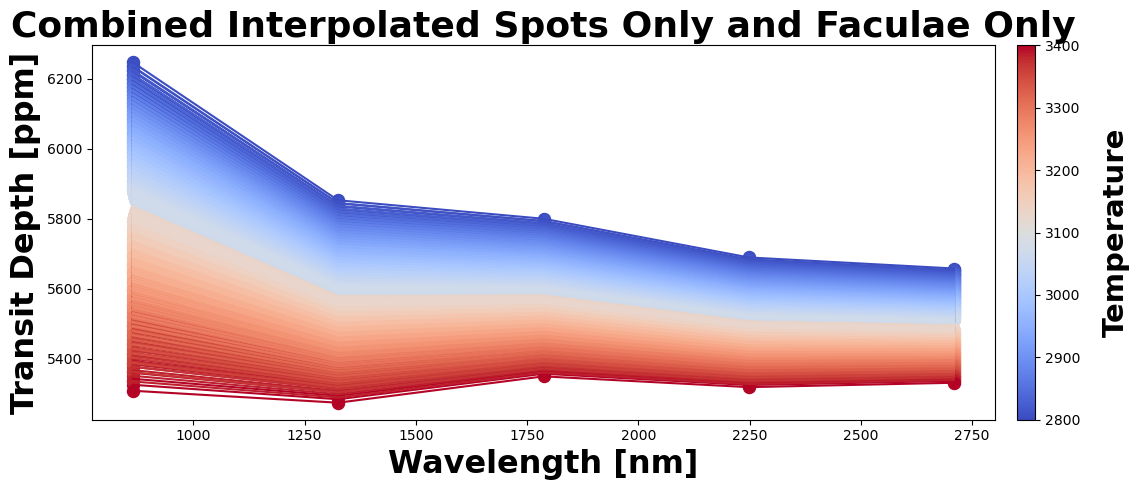

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import os
import matplotlib

# --- Define the file path for the interpolated results based on both_mode ---
if both_mode:
    file_path = f"interpolated_results_{target}_both.txt"
else:
    file_path = f"interpolated_results_{target}_combined.txt"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# --- Load interpolated data ---
data = np.genfromtxt(file_path, delimiter=',', names=True)

# --- Define masks using the temperature columns ---
# Spots Only: valid T_spot and missing T_facula
is_spot_only = ~np.isnan(data['T_spot']) & np.isnan(data['T_facula'])
# Faculae Only: missing T_spot and valid T_facula
is_facula_only = np.isnan(data['T_spot']) & ~np.isnan(data['T_facula'])
# Spots + Faculae: both temperatures available
is_both = ~np.isnan(data['T_spot']) & ~np.isnan(data['T_facula'])

# --- Store generated figures ---
figures = {}

# --- Scale factor for marker size based on filling factor ---
marker_scale = 500  # adjust as needed

if both_mode:
    # ====================================================
    # FIGURE A: Combined plot for Spots Only and Faculae Only
    # ====================================================
    combined = np.concatenate([data[is_spot_only], data[is_facula_only]])
    groups = {}
    for row in combined:
        # For spots only, use 'f_spot' and 'T_spot';
        # for faculae only, use 'f_facula' and 'T_facula'
        if np.isnan(row['T_facula']):
            fill = row['f_spot']
            temp = row['T_spot']
        elif np.isnan(row['T_spot']):
            fill = row['f_facula']
            temp = row['T_facula']
        else:
            continue
        key = (fill, temp)
        if key not in groups:
            groups[key] = {'wavelength': [], 'D': []}
        groups[key]['wavelength'].append(row['wavelength'])
        groups[key]['D'].append(row['D_lambda'])
    
    # Prepare temperature values for color scaling (ignoring NaNs)
    temps = np.array([key[1] for key in groups.keys() if not np.isnan(key[1])])
    if temps.size == 0:
        print("No valid temperature data found for Interpolated Spots Only and Faculae Only. Skipping combined plot.")
    else:
        t_min, t_max = np.nanmin(temps), np.nanmax(temps)
        cmap_t = matplotlib.colormaps["coolwarm"]
        norm_t = Normalize(vmin=t_min, vmax=t_max)
    
        figA, axA = plt.subplots(figsize=(12, 5))
    
        for (fill, temp), values in groups.items():
            if np.isnan(temp):
                continue
            lam_array = np.array(values['wavelength'])
            d_array = np.array(values['D'])
            idx = np.argsort(lam_array)
            size = marker_scale * fill  # Marker size scaled by the filling factor
            color = cmap_t(norm_t(temp))
            axA.scatter(lam_array[idx], d_array[idx], s=size, color=color, alpha=1)
            axA.plot(lam_array[idx], d_array[idx], color=color, alpha=1)
    
        axA.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
        axA.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
        axA.set_title("Combined Interpolated Spots Only and Faculae Only", fontsize=26, fontweight='bold')
    
        smA = ScalarMappable(cmap=cmap_t, norm=norm_t)
        smA.set_array([])
        cbarA = figA.colorbar(smA, ax=axA, orientation='vertical', pad=0.02)
        cbarA.set_label("Temperature", fontsize=21, fontweight='bold', labelpad=15)
    
        figA.tight_layout()
        figures["Combined_Interpolated"] = figA

    # ====================================================
    # FIGURE B: Plot for Spots + Faculae (Interpolated)
    # ====================================================
    figB, axB = plt.subplots(figsize=(12, 5))
    
    if data[is_both].size == 0:
        # No data available for Spots + Faculae in the interpolated file
        axB.text(0.5, 0.5, "No Interpolated Spots+Faculae Data Available", 
                 ha='center', va='center', fontsize=20)
        axB.set_title("Interpolated Spots + Faculae", fontsize=26, fontweight='bold')
        axB.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
        axB.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
    else:
        groups_both = {}
        for row in data[is_both]:
            # Create a key with (f_spot, T_spot, f_facula, T_facula)
            key = (row['f_spot'], row['T_spot'], row['f_facula'], row['T_facula'])
            if key not in groups_both:
                groups_both[key] = {'wavelength': [], 'D': []}
            groups_both[key]['wavelength'].append(row['wavelength'])
            groups_both[key]['D'].append(row['D_lambda'])
    
        # For color mapping, use the facula temperature (column index 3)
        temp_vals = np.array([k[3] for k in groups_both.keys() if not np.isnan(k[3])])
        if temp_vals.size == 0:
            print("No valid facula temperature data found for Interpolated Spots + Faculae. Plotting empty figure.")
        else:
            t_min_b, t_max_b = np.nanmin(temp_vals), np.nanmax(temp_vals)
            cmap_b = matplotlib.colormaps["coolwarm"]
            norm_b = Normalize(vmin=t_min_b, vmax=t_max_b)
    
            for (f_spot, t_spot, f_fac, t_fac), values in groups_both.items():
                if np.isnan(t_fac):
                    continue
                lam_array = np.array(values['wavelength'])
                d_array = np.array(values['D'])
                idx = np.argsort(lam_array)
                size = marker_scale * f_spot  # Marker size based on spot filling factor
                color = cmap_b(norm_b(t_fac))
                axB.scatter(lam_array[idx], d_array[idx], s=size, color=color, alpha=1)
                axB.plot(lam_array[idx], d_array[idx], color=color, alpha=1)
    
            smB = ScalarMappable(cmap=cmap_b, norm=norm_b)
            smB.set_array([])
            cbarB = figB.colorbar(smB, ax=axB, orientation='vertical', pad=0.02)
            cbarB.set_label("Temperature", fontsize=21, fontweight='bold', labelpad=15)
    
        axB.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
        axB.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
        axB.set_title("Interpolated Spots + Faculae", fontsize=26, fontweight='bold')
    
    figB.tight_layout()
    figures["Spots+Faculae_Interpolated"] = figB

else:
    # ====================================================
    # both_mode == False: Only combined plot for Spots Only and Faculae Only (Interpolated)
    # ====================================================
    combined = np.concatenate([data[is_spot_only], data[is_facula_only]])
    groups = {}
    for row in combined:
        if np.isnan(row['T_facula']):
            fill = row['f_spot']
            temp = row['T_spot']
        elif np.isnan(row['T_spot']):
            fill = row['f_facula']
            temp = row['T_facula']
        else:
            continue
        key = (fill, temp)
        if key not in groups:
            groups[key] = {'wavelength': [], 'D': []}
        groups[key]['wavelength'].append(row['wavelength'])
        groups[key]['D'].append(row['D_lambda'])
    
    temps = np.array([key[1] for key in groups.keys() if not np.isnan(key[1])])
    if temps.size == 0:
        print("No valid temperature data found for Interpolated Spots Only and Faculae Only. Skipping combined plot.")
    else:
        t_min, t_max = np.nanmin(temps), np.nanmax(temps)
        cmap_t = matplotlib.colormaps["coolwarm"]
        norm_t = Normalize(vmin=t_min, vmax=t_max)
    
        fig, ax = plt.subplots(figsize=(12, 5))
    
        for (fill, temp), values in groups.items():
            if np.isnan(temp):
                continue
            lam_array = np.array(values['wavelength'])
            d_array = np.array(values['D'])
            idx = np.argsort(lam_array)
            size = marker_scale * fill
            color = cmap_t(norm_t(temp))
            ax.scatter(lam_array[idx], d_array[idx], s=size, color=color, alpha=1)
            ax.plot(lam_array[idx], d_array[idx], color=color, alpha=1)
    
        ax.set_xlabel("Wavelength [nm]", fontsize=23, fontweight='bold')
        ax.set_ylabel("Transit Depth [ppm]", fontsize=23, fontweight='bold')
        ax.set_title("Combined Interpolated Spots Only and Faculae Only", fontsize=26, fontweight='bold')
    
        sm = ScalarMappable(cmap=cmap_t, norm=norm_t)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label("Temperature", fontsize=21, fontweight='bold', labelpad=15)
    
        fig.tight_layout()
        figures["Combined_Interpolated"] = fig

plt.show()